Create Site Table
===

Create a table of the site info from the raw JSON so that it can be processed more quickly and easily.

In [4]:
%matplotlib inline
from IPython.core.display import display, HTML

import os
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

import datetime as dt
import time

from collections import Counter

import json
import os
import re
from html.parser import HTMLParser
import itertools
import multiprocessing as mp
from nltk import word_tokenize
from IPython.core.display import display, HTML
import datetime as dt

from tqdm import tqdm

In [5]:
raw_data_dir = "/home/srivbane/shared/caringbridge/data/raw"
site_filename = os.path.join(raw_data_dir, "site_scrubbed.json")

working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/extract_site_features"
os.makedirs(working_dir, exist_ok=True)

flattened_site_json_filename = os.path.join(working_dir, "site_scrubbed_flat.json")
feathered_site_df_filename = os.path.join(working_dir, "site_scrubbed.df")
csv_site_df_filename = os.path.join(working_dir, "site_scrubbed_flat.csv")


In [6]:
def drop_columns(site):
    # Drop the little-used but still fiddly columns entirely
    cols_to_delete = ["goFundMe", "groups", "pendingLinkSiteId", "test", "transfer"]
    for col in cols_to_delete:
        if col in site:
            del site[col]

def update_date_columns(site):
    date_cols = ["updatedAt", 
                 "createdAt", 
                 "isGoogleableLastUpdated", 
                 "lastCaringBook", 
                 "lastInvite", 
                 "migratedAt", 
                 "publishDate"]
    for col in date_cols:
        if col in site:
            site[col] = site[col]["$date"]
            
def flatten_json_date_field(field_name, json_dict):
    # Flattens a date field in a json dict, assuming that it has a "$date" key in the date field
    if field_name in json_dict:
        json_dict[field_name] = json_dict[field_name]["$date"]

In [7]:
def convert_photo_dict_to_columns(site):
    new_col_defaults = {"photo_count": 0, 
                "photo_widths": "",
                "photo_heights": "",
                "photo_cropped": "",
                "photo_caption": ""}
    if "photo" not in site:
        site.update(new_col_defaults)
        return False
    photo = site["photo"]
    del site["photo"]
    site.update(new_col_defaults)
    if "parts" in photo:
        parts = photo["parts"]
        if type(parts) == list:
            site["photo_count"] = len(parts)
            widths = ""
            heights = ""
            croppeds = ""
            for part in parts:
                width = part["width"] if "width" in part else -1
                height = part["height"] if "height" in part else -1
                cropped = part["cropped"] if "cropped" in part else -1
                widths += str(width) + "|"
                heights += str(height) + "|"
                croppeds += str(cropped) + "|"
            site["photo_widths"] = widths.rstrip("|")
            site["photo_heights"] = heights.rstrip("|")
            site["photo_cropped"] = croppeds.rstrip("|")
    if "caption" in photo:
        site["photo_caption"] = photo["caption"]
    return True

def convert_cm_dict_to_columns(site):
    # TODO Implement me. Currently, we discard the cm column entirely
    if "cm" not in site:
        return False
    del site["cm"]    
    return True

def convert_theme_dict_to_columns(site):
    new_col_defaults = {"theme_cbPhoto": "not provided", 
                        "theme_color": "not provided",
                        "theme_displayWeight": -1,
                        "theme_id": "not provided",
                        "theme_legacyTemplate": "not provided",
                        "theme_title": "not provided"}
    if "theme" not in site:
        site.update(new_col_defaults)
        return False
    theme = site["theme"]
    del site["theme"]
    site.update(new_col_defaults)
    
    # Overwrite with whatever fields are present in the site
    for col in new_col_defaults:
        if col[6:] in theme:
            site[col] = theme[col[6:]]
    return True

def convert_healthCondition_dict_to_columns(site):
    new_col_defaults = {"healthCondition_category": "not provided", 
                        "healthCondition_custom": "not provided", 
                        "healthCondition_name": "not provided"}
    if "healthCondition" not in site:
        site.update(new_col_defaults)
        return False
    healthCondition = site["healthCondition"]
    del site["healthCondition"]
    site.update(new_col_defaults)
    
    # Overwrite with whatever fields are present in the site
    for col in new_col_defaults:
        if col[16:] in healthCondition:
            site[col] = healthCondition[col[16:]]
    return True

def convert_bi_dict_to_columns(site):
    new_col_defaults = {"bi_createHadProfile": -1}
    if "bi" not in site:
        site.update(new_col_defaults)
        return False
    bi = site["bi"]
    del site["bi"]
    site.update(new_col_defaults)
    
    # Overwrite with whatever fields are present in the site
    for col in new_col_defaults:
        if col[3:] in bi:
            site[col] = bi[col[3:]]
    return True

def convert_location_dict_to_columns(site):
    return convert_dict_to_columns("location", site)

def convert_partner_dict_to_columns(site):
    return convert_dict_to_columns("partner", site, coerce_sequences=True)

def convert_status_dict_to_columns(site):
    return convert_dict_to_columns("status", site)

def convert_dict_to_columns(dict_name, site, coerce_sequences=False, convert_dates=True):
    # Creates new columns from a dictionary key, with no defaults.
    # If coerce_sequences is true, lists and dicts are converted to their string representations.
    # If convert_dates is true, than values that are dicts that contain a $date column are collapsed to their date value
    if dict_name not in site:
        return False
    d = site[dict_name]
    del site[dict_name]
    
    # Use whatever fields are present in the dict to create a new column
    for key in d:
        new_col_name = dict_name + "_" + key
        if new_col_name in d:
            raise ValueError(f"Derived column '{new_col_name}' already exists in dict '{dict_name}'.")
        value = d[key]
        if convert_dates and type(value) == dict and "$date" in value:
            flatten_json_date_field(key, d)
            value = d[key]
        if type(value) == dict or type(value) == list:
            if coerce_sequences:
                # Convert the sequence to its string representation
                value = str(value)
            else:  # Don't coerce, so this is an error
                raise TypeError(f"Value of '{f}' in dict '{dict_name}' is an unconvertable type with value '{value}'.")
        site[new_col_name] = value
    return True

In [8]:
def convert_allowList_to_columns(site):
    return convert_int_list_to_columns("allowList", site)

def convert_blockList_to_columns(site):
    return convert_int_list_to_columns("blockList", site)

def convert_dismissedOnboarding_to_columns(site):
    return convert_str_list_to_columns("dismissedOnboarding", site)
    
def convert_isGoogleableLog_to_columns(site):
    return convert_str_list_to_columns("isGoogleableLog", site)

def convert_modules_to_columns(site):
    # "modules" can be both a list or a dict in the site data: we ignore the dicts
    if "modules" in site: 
        if type(site["modules"]) == list:
            return convert_str_list_to_columns("modules", site)
        else:  # if not a list, we silently remove the modules
            del site["modules"]
            return True
    else:  # if key doesn't exist, no changes
        return False

def convert_int_list_to_columns(int_list_name, site):
    # Same as convert_str_list_to_columns, but insists that list items are ints and removes duplicates
    new_col_defaults = {int_list_name: "", int_list_name+"_count": 0}
    if int_list_name not in site:
        site.update(new_col_defaults)
        return False
    intList = site[int_list_name]
    site.update(new_col_defaults)
    if type(intList) == list and len(intList) > 0:
        idSet = set()
        for item in intList:
            idSet.add(int(item))
        idList = [str(item) for item in sorted(list(idSet))]
        intListStr = "|".join(idList)
        site[int_list_name] = intListStr
        site[int_list_name+"_count"] = len(idList)
    return True

def convert_str_list_to_columns(str_list_name, site):
    new_col_defaults = {str_list_name: "", str_list_name+"_count": 0}
    if str_list_name not in site:
        site.update(new_col_defaults)
        return False
    strList = site[str_list_name]
    site.update(new_col_defaults)
    if type(strList) == list and len(strList) > 0:
        itemList = []
        for item in strList:
            itemList.append(str(item))
        strListStr = "|".join(itemList)
        site[str_list_name] = strListStr
        site[str_list_name+"_count"] = len(itemList)
    return True

In [33]:
processed_count = 0
with open(site_filename, 'r', encoding="utf8") as infile:
    with open(flattened_site_json_filename, 'w', encoding="utf8") as outfile:
        for line in tqdm(infile, total=588210):
            site = json.loads(line.strip())
            
            convert_cm_dict_to_columns(site)
            convert_theme_dict_to_columns(site)
            convert_healthCondition_dict_to_columns(site)
            convert_photo_dict_to_columns(site)
            convert_bi_dict_to_columns(site)
            convert_location_dict_to_columns(site)
            convert_partner_dict_to_columns(site)
            convert_status_dict_to_columns(site)
            
            convert_allowList_to_columns(site)
            convert_blockList_to_columns(site)
            convert_dismissedOnboarding_to_columns(site)
            convert_isGoogleableLog_to_columns(site)
            convert_modules_to_columns(site)
            
            drop_columns(site)
            update_date_columns(site)
            
            # Write the revised site to the intermediate output file
            json.dump(site, outfile, ensure_ascii=False)
            outfile.write('\n')

100%|██████████| 588210/588210 [02:21<00:00, 4157.96it/s]


In [39]:
!wc -l {flattened_site_json_filename}

588210 /home/srivbane/shared/caringbridge/data/projects/qual-health-conditions/extract_site_features/site_scrubbed_flat.json


In [35]:
%%time
# Load a dataframe from the json
with open(flattened_site_json_filename, 'r', encoding="utf8") as infile:
    df = pd.read_json(infile, orient="records", lines=True, chunksize=None)

CPU times: user 1min 39s, sys: 11.8 s, total: 1min 51s
Wall time: 1min 5s


In [36]:
%%time
# Save the loaded dataframe in the feather format
df.to_feather(feathered_site_df_filename)

CPU times: user 3.97 s, sys: 880 ms, total: 4.85 s
Wall time: 6.28 s


In [56]:
%%time
# Save the loaded dataframe in the CSV format
df.to_csv(csv_site_df_filename)

CPU times: user 45.6 s, sys: 964 ms, total: 46.6 s
Wall time: 48 s


In [9]:
%%time
df = pd.read_feather(feathered_site_df_filename)

CPU times: user 1.74 s, sys: 1.4 s, total: 3.14 s
Wall time: 7.77 s


In [10]:
# How large is the dataframe in RAM?
def sizeof_fmt(num, suffix='B'):
    #Source: https://stackoverflow.com/questions/1094841/reusable-library-to-get-human-readable-version-of-file-size
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

sizeof_fmt(sum(df.memory_usage(deep=True)))

'2.1 GiB'

In [54]:
# Print the column names, pandas dtype, and pyarrow dtype
import pyarrow
for index in df.dtypes.index:
    dtype = str(df.dtypes[index])
    arrow_dtype = str(pyarrow.lib.array(df[index], from_pandas=True).type)
    print(f"{index:45}{dtype:15}{arrow_dtype:15}")
    

_id                                          int64          int64          
age                                          object         string         
allowList                                    object         string         
allowList_count                              int64          int64          
bi_createHadProfile                          int64          int64          
blockList                                    object         string         
blockList_count                              int64          int64          
calendarId                                   float64        double         
createFormSessionId                          float64        double         
createdAt                                    float64        double         
description                                  object         string         
dismissedOnboarding                          object         string         
dismissedOnboarding_count                    int64          int64          
displayEmail

In [53]:
len(df[df["healthCondition_category"] != "not provided"]) / len(df)

0.3805715645772768

In [15]:
Counter(df["age"])

Counter({'adult': 254115,
         'teen': 16586,
         'baby': 23684,
         'child': 31689,
         None: 262136})

In [21]:
Counter(df["healthCondition_category"])

Counter({'not provided': 364354,
         'custom': 35921,
         'Neurological Condition': 9421,
         'Injury': 12713,
         'Cancer': 104500,
         'Surgery/Transplantation': 15503,
         'Condition Unknown': 2938,
         'Infant/Childbirth': 8651,
         '': 14963,
         'Other': 4848,
         'Congenital/Immune Disorder': 2118,
         'Cardiovascular/Stroke': 12280})

In [20]:
df[df["age"] == "baby"]["numTributes"].describe()

count    21932.000000
mean         1.670299
std          4.608363
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        165.000000
Name: numTributes, dtype: float64

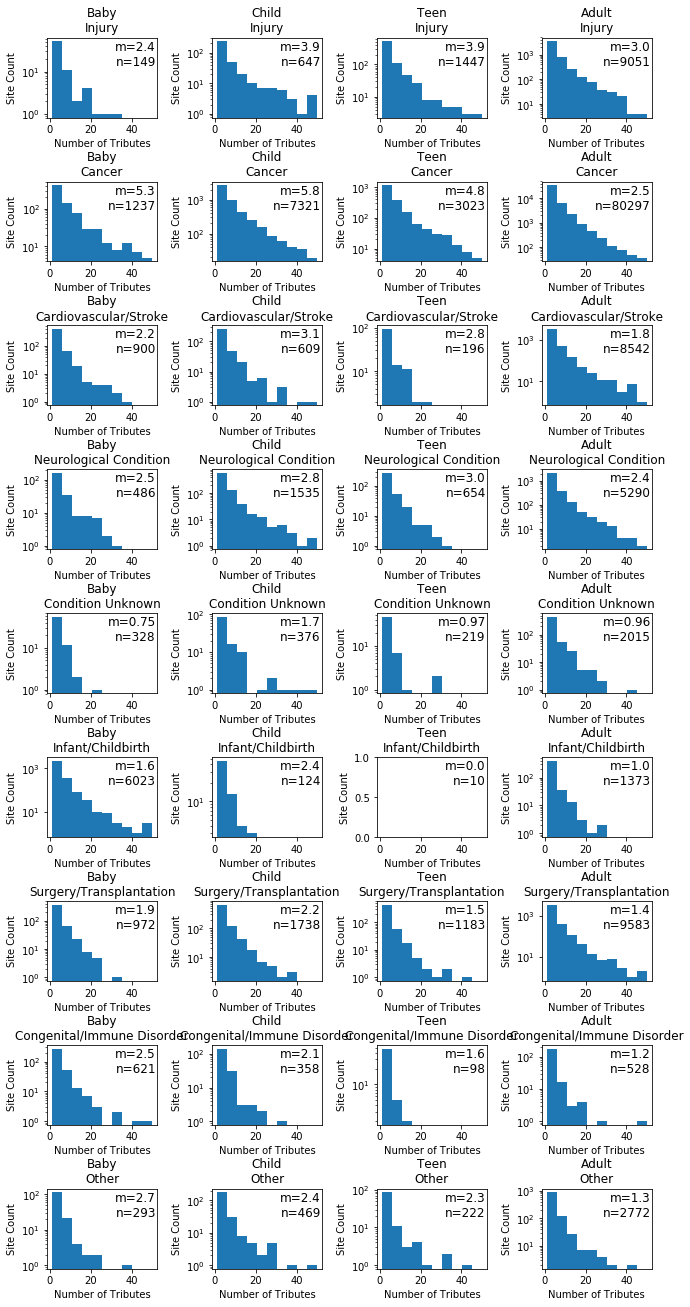

In [62]:
healthCondition_categories = [hc for hc in list(set(df["healthCondition_category"])) if len(hc) > 0 and hc[0].isupper()]
age_groups = [age for age in list(set(df["age"])) if age]
n_cols = len(age_groups)
n_rows = len(healthCondition_categories)

title = "Tributes by Health Condition and Age"
fig, axes = pl.subplots(n_rows, n_cols, num=title, sharey=False, sharex="row", figsize=(3*n_cols,5*n_rows), squeeze=False)
for row, hc_category in zip(range(n_rows), healthCondition_categories):
    for i, ax in enumerate(axes[row]):
        age_group = age_groups[i]
        ax.set_title(f"{age_group.title()}\n{hc_category}")

        df_subset = df[(df["age"] == age_group) & (df["healthCondition_category"] == hc_category)]
        #df_subset = df.query("age == ")
        series = df_subset["numTributes"]
        
        x = [v for v in series.dropna().tolist() if v > 0]
        
        bins = np.linspace(1, 50, num=11)
        if len(x) > 0:
            ax.hist(x, log=True, bins=bins)
        
        mean = np.mean(series.dropna())
        n = len(series.dropna())
        ax.text(0.99, 0.97, f"m={mean:.2}\nn={n}", transform=ax.transAxes, horizontalalignment="right", verticalalignment="top", fontsize=12)

        #if row == n_rows - 1:
        #    pass
        #    #ax.set_xticks(xticks)
        #    #ax.set_xticklabels(xticklabels, rotation="vertical")
        #else:
        #    ax.set_xticks([])

        ax.set_xlabel("Number of Tributes")
        ax.set_ylabel("Site Count")

plt.subplots_adjust(bottom=0.5, left=0.2, hspace=0.8, wspace=0.5)  # create extra space for large labels
# can also use "hspace=
#plt.tight_layout()
plt.show()


In [73]:
np.sum(df["numTributes"] > 0) / len(df)

0.2527413678788188

In [71]:
df[df["_id"] == 700]["numTributes"]

1381    5.0
Name: numTributes, dtype: float64